# Restricted Boltzman machine

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

## Data

In [3]:
patterns = np.zeros((14,3,3))

patterns[0] = np.array([[-1,-1,-1],[-1,-1,-1],[-1,-1,-1]])
patterns[1] = np.array([[1,-1,-1],[1,-1,-1],[1,-1,-1]])
patterns[2] = np.array([[-1,1,-1],[-1,1,-1],[-1,1,-1]])
patterns[3] = np.array([[-1,-1,1],[-1,-1,1],[-1,-1,1]])
patterns[4] = np.array([[1,1,-1],[1,1,-1],[1,1,-1]])
patterns[5] = np.array([[-1,1,1],[-1,1,1],[-1,1,1]])
patterns[6] = np.array([[1,-1,1],[1,-1,1],[1,-1,1]])
patterns[7] = np.array([[1,1,1],[1,1,1],[1,1,1]])
patterns[8] = np.array([[1,1,1],[-1,-1,-1],[-1,-1,-1]])
patterns[9] = np.array([[-1,-1,-1],[1,1,1],[-1,-1,-1]])
patterns[10] = np.array([[-1,-1,-1],[-1,-1,-1],[1,1,1]])
patterns[11] = np.array([[1,1,1],[1,1,1],[-1,-1,-1]])
patterns[12] = np.array([[-1,-1,-1],[1,1,1],[1,1,1]])
patterns[13] = np.array([[1,1,1],[1,1,1],[-1,-1,-1]])

In [4]:
patterns = patterns.reshape(-1,9)

In [5]:
class DataLoader:
    
    def __init__(self,data,po):
        self.data = data
        self.po = po
    
    def __iter__(self):
        return self

    def __next__(self):
        index = np.random.choice(range(len(self.data)), self.po, replace=False)
        return self.data[index]

## Restricted Boltzman machine Class

In [6]:
class RBM:
    def __init__(self, nv, nh, beta=1, cd_k=1):   
        self.W = 2*np.random.rand(nh,nv) - 0.5
        self.teta_v = 2*np.random.rand(nv) - 0.5
        self.teta_h = 2*np.random.rand(nh) -0.5
        self.cd_k = cd_k 
        self.nv = nv
        self.nh = nh
        self.beta = beta
    
    def _p(self,b):
        return 1/(1+np.exp(-self.beta*b))         
    
    def activate_neuron_h(self,x):
        b_h = self.W@x - self.teta_h
        p_h= self._p(b_h)
        h = np.zeros(self.nh)
        for i in range(self.nh):
            h[i] = np.random.choice([-1,1],p=[p_h[i],1-p_h[i]])

        return h,b_h

    def activate_neuron_v(self,h):
        b_v = h.T@self.W - self.teta_v
        p_v = self._p(b_v)
        v = np.zeros(self.nv)
        for j in range(self.nv):
            v[j] = np.random.choice([-1,1],p=[p_v[j],1-p_v[j]])

        return v,b_v
    
    def forward(self,x):
        h,b_0 = self.activate_neuron_h(x)
        for t in range(self.cd_k):
            v,_ = self.activate_neuron_v(h)
            h,b_k = self.activate_neuron_h(v)
        
        return v,h,b_0,b_k

    def __call__(self,x): 
        return self.forward(x)[0]
    

## Training with Dkl info

In [7]:
N = 9
M = 6
rbm = RBM(N,M,cd_k=100)
po = 14
data = DataLoader(patterns,po)
data_dkl = DataLoader(patterns,patterns.shape[0])
rbm_list = [RBM(N,M,cd_k=100) for M in [2,4,8,16]]
list_dkl = [[] for _ in range(4)]

In [12]:
%%time
epochs = 2000

lr = 0.1
average_pb_iter =250

dkl_freq = 200

list_dkl = [[] for _ in range(4)]

for idx,rbm in enumerate(rbm_list):

    for epoch in tqdm(range(epochs)):
        dW = np.zeros(rbm.W.shape)
        dTeta_h = np.zeros(rbm.teta_h.shape)
        dTeta_v = np.zeros(rbm.teta_v.shape)

        po_patterns = next(data)

        for x in po_patterns:
            v,h,b_0,b_k = rbm.forward(x)
            for m in range(rbm.nh):
                for n in range(rbm.nv):
                    dW[m,n] += lr*(np.tanh(b_0[m])*x[n] - np.tanh(b_k[m]*v[n]))
                    dTeta_v[n] += lr*(x[n]-v[n])
                    dTeta_h[m] += lr*(np.tanh(b_0[m])-np.tanh(b_k[m])*v[n])

        rbm.W = rbm.W + dW
        rbm.teta_h = rbm.teta_h + dTeta_h
        rbm.teta_v = rbm.teta_v + dTeta_v


    ## calculate dkl
        if (epoch == 0 or epoch%dkl_freq == 0 or epoch == epochs-1):
            dkl = 0
            patterns_dkl = next(data_dkl)
            p_b = np.ones(patterns_dkl.shape[0])

            for i in range(average_pb_iter):
                x = np.random.choice([-1,1],p=[0.5,0.5],size=(9))
                y = rbm(x)

                for j,p in enumerate(patterns_dkl):
                    if (y==p).all():
                        p_b[j] += 1
                        break
            
            p_b = p_b/(average_pb_iter+patterns_dkl.shape[0])
            for p in p_b:
                dkl += (1/14 * np.log(1/14 / p))

            list_dkl[idx].append(dkl)

  0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-6-5065bbf8eda5>:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-self.beta*b))
100%|██████████| 2000/2000 [26:01<00:00,  1.28it/s]  

CPU times: user 1h 11min 54s, sys: 7min 19s, total: 1h 19min 13s
Wall time: 1h 11min 43s


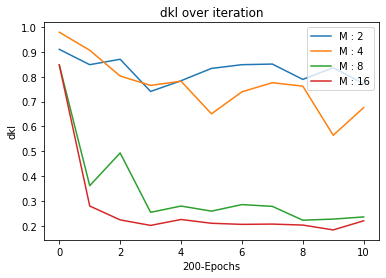

In [13]:
for i,dkl in enumerate(list_dkl):
    plt.plot(dkl,label=f"M : {[2,4,8,16][i]}")
plt.title("dkl over iteration")
plt.ylabel("dkl")
plt.xlabel(f"{dkl_freq}-Epochs")
plt.legend(loc="upper right")

## Testing the model on stripped stored pattern

In [17]:
for pattern in patterns:
    
    test_pattern = np.zeros(9)
    for i in range(3):
        test_pattern[i] = pattern[i]
    
    reco_pattern = rbm(test_pattern)
    print((pattern == reco_pattern).all())

False
False
False
False
False
True
False
False
False
False
False
True
True
True
